# Exercises

Discrete Data + Probability

Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.


In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns


# Acquire

In [2]:
# create list of column names to use for dataframe
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']

# read the csv, there is a lot of exceptions/narly data to parse
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

# this creates some new data that is not in the original csv
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

# this appends the new data with what the csv brings in 
df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   status          13978 non-null  int64  
 3   size            13978 non-null  int64  
 4   destination     13978 non-null  object 
 5   request_agent   13978 non-null  object 
 6   size_mb         13978 non-null  float64
 7   ip_proba        13978 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 982.8+ KB


# Prepare

In [4]:
# first clean up the timestamp column so it is recognized as a timestamp
# remove the brackets
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
# replace the : with a space
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
# set the timestamp as the index for time series analysis(TSA)
df = df.set_index('timestamp')

In [5]:
# cleanup the text
# get rid of the quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
# remove the page #
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [6]:
# add a feature that converts size in bytes to MB
df['size_mb'] = [n/1024/1024 for n in df['size']]

# Look for anomalies in IP address

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   status          13978 non-null  int64  
 3   size            13978 non-null  int64  
 4   destination     25 non-null     object 
 5   request_agent   13978 non-null  object 
 6   size_mb         13978 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 873.6+ KB


In [8]:
df.ip.count()

13978

In [9]:
# first create a dataframe of the unique values in the IP address column and
# the count of the occurances of that address
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
# now create dataframe of probability of that ip appearing in the dataset
# probability is the count of occurances of that ip address in the data divided by the total occurances(rows)
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [10]:
ip_df.head()

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [11]:
ip_df2.head()

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,24.26.242.9,0.001502


In [12]:
# merge these two dataframes together
ip_df = ip_df.merge(ip_df2)

# see those where rate < 1% 
# look for the addresses that occur rarely, less than 1% of the time
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,54.172.14.223,1,0.000072
10,35.174.209.2,1,0.000072
11,3.92.201.136,1,0.000072
12,3.88.129.158,1,0.000072
13,45.23.250.16,1,0.000072


22
               ip  ip_count  ip_proba
12   3.88.129.158         1  0.000072
13   45.23.250.16         1  0.000072
14   95.31.18.119         1  0.000072
15  52.90.165.200         1  0.000072
16   52.91.30.150         1  0.000072
17  34.207.64.242         1  0.000072
18  54.145.52.184         1  0.000072
19   95.31.16.121         1  0.000072
20  34.229.70.250         1  0.000072
21  97.105.15.120         1  0.000072


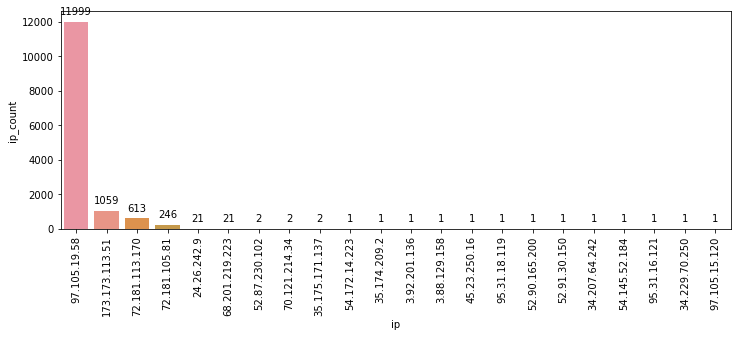

In [13]:
# this tells us there are 22 unique IP addresses
print(len(ip_df))

# this prints the last 10 rows in the dataframe
print(ip_df.tail(10))

# set the chart figure size
plt.figure(figsize=(12, 4))
# make a seaborn barplot, 'ci = None' means no bootstrapping/error bars will be drawn
# https://seaborn.pydata.org/generated/seaborn.barplot.html
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)

# this rotates the x labels, and puts the total # of occurances for each IP address at the top of that column 
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives.

In [14]:
pd.__version__

'1.1.3'

In [15]:
# establish a baseline
# create a train dataset that is from specific date range, specify columns in dataframe
#train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]
# this produces a werid numpy but

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]
# this code from Adam works

In [16]:
train.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13974 entries, 2019-04-16 19:34:42+00:00 to 2019-04-17 12:55:14+00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13974 non-null  object 
 1   request_method  13974 non-null  object 
 2   status          13974 non-null  int64  
 3   size            13974 non-null  int64  
 4   destination     25 non-null     object 
 5   request_agent   13974 non-null  object 
 6   size_mb         13974 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 873.4+ KB


In [17]:
# compute probabilities based on train sample
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [19]:
ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


In [22]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ip        19 non-null     object 
 1   ip_proba  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 456.0+ bytes


In [18]:
# merge the probabilities with all data
# where the IP address is new (not found in train set) fill with 0
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

In [20]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   status          13978 non-null  int64  
 3   size            13978 non-null  int64  
 4   destination     13978 non-null  object 
 5   request_agent   13978 non-null  object 
 6   size_mb         13978 non-null  float64
 7   ip_proba        13978 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 982.8+ KB


# Conditional probabilities
- Probabilities using 2 discrete variables
    - Probability of Status given IP Address
    - If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [25]:
ip_probs = train.groupby('ip').size().div(len(df))
ip_probs

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
97.105.19.58      0.858349
dtype: float64

In [26]:
# define list of unique IP with it's probability of occuring
ip_probs = train.groupby('ip').size().div(len(df))

# create a dataframe with IP, status, and probability of that status message give that specific IP address
# is there a status code that is werid for the IP address?
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [28]:
status_given_ip
# results show only 2 IP addresses have more than 1 status code, and that status code has a very low probability

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [30]:
# create a df with same columns as status given IP
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))

# merge the calculated probabilities with the status count
ip_status = status_given_ip.merge(ip_status_count)

In [32]:
ip_status
# results show the number of times a specific IP received a specific status message
# note: 499 is request canceled by user, 200 is ok

,ip,status,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000286,1059
1,24.26.242.9,200,1.000286,21
2,3.88.129.158,200,1.000286,1
3,3.92.201.136,200,1.000286,1
4,34.207.64.242,200,1.000286,1
5,34.229.70.250,200,1.000286,1
6,35.174.209.2,200,1.000286,1
7,35.175.171.137,200,1.000286,2
8,45.23.250.16,200,1.000286,1
9,52.87.230.102,200,1.000286,2


In [33]:
# add these probabilities to the original df to look for anomalies
# where there is no probability in the training set, fill with 0
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

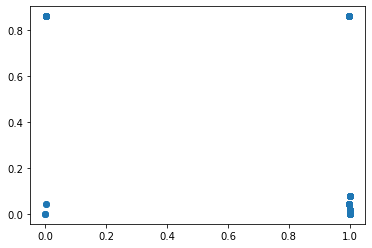

In [34]:
# creates a scatter plot of the probability of the status code given the IP with the probability of that ID
plt.scatter(df.proba_status_given_ip, df.ip_proba)

In [35]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


# very simplified example from Ryan

train, test
 
train = ['cat', 'cat', 'cat', 'dog']

cat probability is 3/4 

dog probability is 1/4

using in-sample values/frequencies to create

expected values for out-of-sample data

test = ['cat', 'cat', 'dog', 'sloth']

baseline = cat

train, test, baseline_correct, exists_in_train, is_novel

cat, cat, 1, 1, 0

cat, cat, 1, 1, 0

cat, dog, 0, 1, 0

dog, sloth, 0, 0, 1

accuracy of a baseline = 50%

eval[eval.exists_in_train == 0]

eval[eval.is_novel == 1]
